In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import scipy.signal as signal


from matplotlib.lines import Line2D
import matplotlib.patches as mpatches


import string
alphabet = list(string.ascii_lowercase)
          

In [2]:
G_ds = xr.open_dataset('Outputs/G_pulse_ds.nc4')['__xarray_dataarray_variable__']
G_cdr_ds = xr.open_dataset('Outputs/G_cdr_ds.nc4')['__xarray_dataarray_variable__']

G_ds = xr.concat([G_ds, -G_cdr_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))

G_ds = G_ds.rename({'year':'s'})

In [3]:
G_climatology_ds = xr.open_dataset('Outputs/G_ds_climatology.nc4')['__xarray_dataarray_variable__']
G_cdr_climatology_ds = xr.open_dataset('Outputs/G_cdr_ds_climatology.nc4')['__xarray_dataarray_variable__']

G_climatology_ds = xr.concat([G_climatology_ds, -G_cdr_climatology_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))

G_climatology_ds = G_climatology_ds.rename({'year':'s'})

In [4]:
Gpoly_clim = G_climatology_ds.polyfit('s', 4)
Gpolyfit_clim= xr.polyval(G_climatology_ds.s, Gpoly_clim)['polyfit_coefficients']

In [5]:
G_poly_ds = xr.open_dataset('Outputs/G_poly_ds.nc4')
G_cdr_poly_ds = xr.open_dataset('Outputs/G_poly_cdr_ds.nc4')

G_poly_ds = xr.concat([G_poly_ds, -G_cdr_poly_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))

G_poly_ds = G_poly_ds.rename({'year':'s'})

In [6]:
A = utils.A

In [7]:
model_color = utils.model_color

In [8]:
type_color = utils.type_color

In [10]:
conv_mean_ds = xr.open_dataset('Outputs/conv_mean_ds.nc4')['__xarray_dataarray_variable__']

conv_ds = xr.open_dataset('Outputs/conv_ds.nc4')['__xarray_dataarray_variable__']

conv_hist_mod_mean_ds = xr.open_dataset('Outputs/hist_co2_only_conv_ds.nc4')['__xarray_dataarray_variable__']




In [11]:
conv_4x_ds = xr.open_dataset('Outputs/4x_conv_ds.nc4')['__xarray_dataarray_variable__']


In [12]:
ds_dif = xr.open_dataset('Outputs/ds_dif.nc4')

ds_hist_dif = xr.open_dataset('Outputs/hist_co2_only_ds_dif.nc4')

In [13]:
ds_4x_dif = xr.open_dataset('Outputs/4x_ds_dif.nc4')


In [14]:
model_run_pulse_dict = utils.model_run_pulse_dict
model_run_1pct_dict = utils.model_run_1pct_dict
model_run_control_dict = utils.model_run_esm_picontrol_dict
model_run_1pct1000gtc_dict = utils.model_run_1pct_1000gtc_dict


In [16]:
type_color = utils.type_color
model_color = utils.model_color

In [17]:
A = utils.A
ds_out = utils.ds_out

In [18]:
proper_names = utils.proper_names

In [19]:
RTCRE = xr.open_dataset('Outputs/RTCRE.nc')['__xarray_dataarray_variable__']

## Model level TCRE Convolution

In [20]:
emis_profile = xr.open_dataset('Outputs/emis_profile.nc4')
emis_profile_4x = xr.open_dataset('Outputs/4x_emis_profile.nc4')
emis_profile_hist = xr.open_dataset('Outputs/hist_co2_only_emis_profile.nc4')


In [21]:
emis_profile_4x = emis_profile_4x['emis'].expand_dims(dim ={'experiment':['4x']}).weighted(utils.fourx_model_weights).mean(dim = 'model')
emis_profile_hist = emis_profile_hist['emis'].expand_dims(dim ={'experiment':['hist']}).mean(dim = 'model')
emis_profile_1000gtc = emis_profile['emis'].where(ds_dif.model.isin(list(utils.model_run_1pct_1000gtc_dict.keys())), drop = True).sel(experiment = '1000gtc').weighted(utils.onepct_1000gtc_weights).mean(dim = 'model')
emis_profile_1pct = emis_profile['emis'].where(ds_dif.model.isin(list(utils.model_run_1pct_dict.keys())), drop = True).sel(experiment = '1pct').weighted(utils.onepct_model_weights).mean(dim = 'model')

In [22]:
emis_profile = xr.concat([emis_profile_1pct, emis_profile_1000gtc, emis_profile_hist, emis_profile_4x], dim = 'experiment')

In [37]:
emis_profile = emis_profile.rename({'year':'s'})

In [28]:
RTCRE_conv = RTCRE*emis_profile.cumsum('s')

## TCRE and ZEC

In [41]:

def reindex_df(df, weight_col):
    """expand the dataframe to prepare for resampling
    result is 1 row per count per sample"""
    df = df.reindex(df.index.repeat(df[weight_col]))
    df.reset_index(drop=True, inplace=True)
    return(df)


data = {'mean': conv_mean_ds.sel(experiment = '1000gtc').mean(dim = ['pulse_type']).sel(s = slice(60,80)).mean(dim = ['s']).values,
        'model': conv_mean_ds.model.values,
        'count': [3, 3, 3, 3, 12, 12, 12, 12, 4, 4, 4]} #weighting for the fact that some models have multiple realizations
df_1000gtc_emulator = pd.DataFrame(data)
df_1000gtc_emulator = reindex_df(df_1000gtc_emulator, weight_col = 'count')

data = {'mean': conv_mean_ds.sel(experiment = '1pct').mean(dim = ['pulse_type']).sel(s = slice(60,80)).mean(dim = ['s']).values,
        'model': conv_mean_ds.model.values,
        'count': [3, 3, 3, 3, 12, 12, 12, 12, 4, 4, 4]} #weighting for the fact that some models have multiple realizations
df_1pct_emulator = pd.DataFrame(data)
df_1pct_emulator = reindex_df(df_1pct_emulator, weight_col = 'count')


data = {'mean': ds_dif.where(ds_dif['model'].isin(utils.model_weights.model.values), drop = True).sel(experiment = '1pct').sel(s = slice(60,80)).weighted(A).mean(dim = ['s', 'lon','lat'])['tas'].values,
        'model': ds_dif.where(ds_dif['model'].isin(utils.model_weights.model.values), drop = True).sel(experiment = '1pct').model.values,
        'count': [3, 3, 3, 3, 12, 12, 12, 12, 4, 4, 4]} #weighting for the fact that some models have multiple realizations

df_1pct_model = pd.DataFrame(data)
df_1pct_model = reindex_df(df_1pct_model, weight_col = 'count')


#######ZEC############

data = {'mean': (conv_mean_ds.sel(experiment = '1000gtc').where(conv_mean_ds['model'].isin(list(model_run_1pct1000gtc_dict.keys())), drop = True).mean(dim = 'pulse_type').sel(
                                                                s = slice(80-10, 80+10)).mean(dim = 's').weighted(A).mean(dim = ['lat','lon']) - 
                    conv_mean_ds.sel(experiment = '1000gtc').where(conv_mean_ds['model'].isin(list(model_run_1pct1000gtc_dict.keys())), drop = True).mean(dim = 'pulse_type').sel(s = 65).weighted(A).mean(dim = ['lat','lon'])).values,
        'model': conv_mean_ds.where(conv_mean_ds['model'].isin(list(model_run_1pct1000gtc_dict.keys())), drop = True).model.values,
        'count': [3, 3, 3, 3, 12, 12, 12, 4, 4, 4]}

df_zec_emulator_model = pd.DataFrame(data)
df_zec_emulator_model = reindex_df(df_zec_emulator_model, weight_col = 'count')




data = {'mean': (ds_dif.where(ds_dif['model'].isin(list(model_run_1pct1000gtc_dict.keys())), drop = True).sel(experiment = '1000gtc').sel(
                                                                s = slice(80-10, 80+10)).mean(dim = 's').weighted(A).mean(dim = ['lat','lon']) - 
                    ds_dif.where(ds_dif['model'].isin(list(model_run_1pct1000gtc_dict.keys())), drop = True).sel(experiment = '1000gtc').sel(s = 65).weighted(A).mean(dim = ['lat','lon']))['tas'].values,
        
        'model': ds_dif.where(ds_dif['model'].isin(list(model_run_1pct1000gtc_dict.keys())), drop = True).sel(experiment = '1000gtc').model.values,
        'count': [3, 3, 3, 3, 12, 12, 12, 4, 4, 4]}

df_zec_cmip_model = pd.DataFrame(data)
df_zec_cmip_model = reindex_df(df_zec_cmip_model, weight_col = 'count')

## Global Mean plots

In [19]:
roll_amt_color_dict = {5:'goldenrod',10: 'forestgreen', 30:'darkblue'}

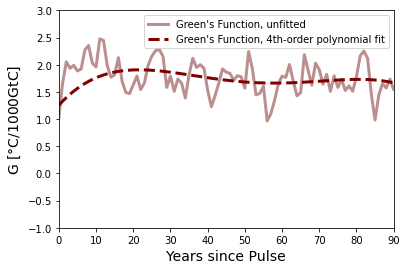

In [48]:
fig, ax1 = plt.subplots(figsize = [6,4])
GtC_per_TtC = 1e3
####Plot the GF
(G_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = ['model','pulse_type'])*GtC_per_TtC).plot(ax = ax1, label = 'Green\'s Function, unfitted', color = 'rosybrown', linewidth = 3)

(G_poly_ds['tas_polyfit_coefficients'].sel(polyfit_type = 'normal_base_pulse').weighted(A).mean(dim = ['lat','lon']).mean(dim = ['model','pulse_type'])*GtC_per_TtC).plot(ax = ax1, label = 'Green\'s Function, 4th-order polynomial fit', color = type_color['emulator_1pct'], linestyle = '--', linewidth = 3);

ax1.set_ylabel('G [$\degree$C/1000GtC]', fontsize = 14)
ax1.legend()
ax1.set_xlim(0,90)
ax1.set_ylim(-1, 3)
ax1.set_title('')
#ax1.grid(alpha = 0.2)
ax1.set_xlabel('Years since Pulse', fontsize = 14)
plt.savefig('figures/talks/G_mean.png', bbox_inches = 'tight', dpi = 250)

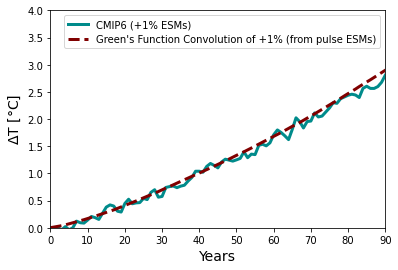

In [27]:
fig, ax1 = plt.subplots(figsize = [6,4])
GtC_per_TtC = 1e3

###Plot the 1pct model runs
ax1.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(model_weights).mean(dim = 'model').weighted(A).mean(dim = ['lat','lon']).sel(experiment = '1pct')['tas'], 
         label = 'CMIP6 (+1% ESMs)', color = type_color['model_1pct'], linewidth = 3)

ax1.plot(conv_mean_ds.weighted(model_weights).mean(dim = ['model', 'pulse_type']).sel(experiment = '1pct'), label = f'Green\'s Function Convolution of +1% (from pulse ESMs)', 
         color = type_color['emulator_1pct'], linestyle = '--', linewidth = 3)

ax1.set_ylabel('$\Delta$T [$\degree$C]', fontsize = 14)
ax1.legend()
ax1.set_xlim(0,90)
ax1.set_ylim(0, 4)
ax1.set_title('')
#ax1.grid(alpha = 0.2)
ax1.set_xlabel('Years', fontsize = 14)
plt.savefig('figures/talks/1pct_global_mean.png', bbox_inches = 'tight', dpi = 250)

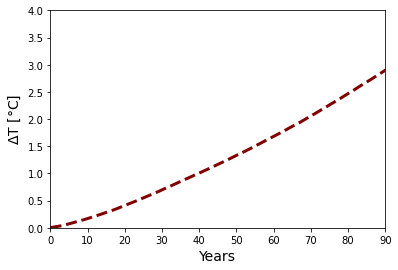

In [28]:
fig, ax1 = plt.subplots(figsize = [6,4])
GtC_per_TtC = 1e3

ax1.plot(conv_mean_ds.weighted(utils.model_weights).mean(dim = ['model', 'pulse_type']).sel(experiment = '1pct'), label = f'Green\'s Function', 
         color = type_color['emulator_1pct'], linestyle = '--', linewidth = 3)

ax1.set_ylabel('$\Delta$T [$\degree$C]', fontsize = 14)
#ax1.legend()
ax1.set_xlim(0,90)
ax1.set_ylim(0, 4)
ax1.set_title('')
#ax1.grid(alpha = 0.2)
ax1.set_xlabel('Years', fontsize = 14)
plt.savefig('figures/talks/1pct_global_mean_GF_only.png', bbox_inches = 'tight', dpi = 250)

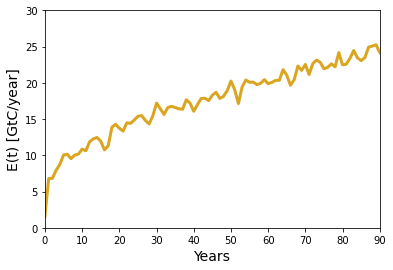

In [23]:
fig, ax1 = plt.subplots(figsize = [6,4])
GtC_per_TtC = 1e3

###Plot the 1pct model runs
emis_profile.sel(experiment = '1pct').plot(ax = ax1, linewidth = 3, color = 'goldenrod')

ax1.set_ylabel('E(t) [GtC/year]', fontsize = 14)
ax1.set_xlim(0,90)
ax1.set_ylim(0, 30)
ax1.set_title('')
#ax1.grid(alpha = 0.2)
ax1.set_xlabel('Years', fontsize = 14)
plt.savefig('figures/talks/1pct_emis.png', bbox_inches = 'tight', dpi = 250)